In [2]:


import pandas as pd
import re
import time
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns



# Load the data
df = pd.read_csv('bugs-train.csv')


# Data Cleaning Function
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    return text

# Apply text cleaning
print('Applying text cleaning...')
df['cleaned_summary'] = df['summary'].astype(str).apply(clean_text)

# Encode severity labels
print('Encoding severity labels...')
label_encoder = LabelEncoder()
df['severity_encoded'] = label_encoder.fit_transform(df['severity'])

# Vectorize text data using TF-IDF
print('Vectorizing text data using TF-IDF...')
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['cleaned_summary'])
y = df['severity_encoded']



# Split data into training, validation, and testing sets
print('Splitting data into training, validation, and testing sets...')
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Compute class weights
print('Computing class weights...')
class_weights = dict(Counter(y_train))
total = sum(class_weights.values())
class_weights = {cls: total / count for cls, count in class_weights.items()}

# Define models with initial hyperparameters
print('Defining models with initial hyperparameters...')
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weights)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Define hyperparameter distributions for RandomizedSearchCV
rf_param_dist = {
    'n_estimators': randint(50, 100),  # Reduce number of trees
    'max_depth': [None, 10, 20],  # Limit tree depth
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['sqrt', 'log2']  # Use a subset of features
}

xgb_param_dist = {
    'n_estimators': randint(50, 100),  # Reduce number of trees
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),  # Generates values in the range [0.7, 1.0]
    'colsample_bytree': uniform(0.7, 0.3)  # Generates values in the range [0.7, 1.0]
}

# Hyperparameter tuning using RandomizedSearchCV on the training data
print('Starting hyperparameter tuning for Random Forest...')
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_dist, n_iter=10, cv=3, scoring='f1_macro', n_jobs=-1, random_state=42)
print('Starting hyperparameter tuning for XGBoost...')
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_dist, n_iter=10, cv=3, scoring='f1_macro', n_jobs=-1, random_state=42)

# Fit the random search models
print('Fitting Random Forest random search...')
rf_random_search.fit(X_train, y_train)
print('Fitting XGBoost random search...')
xgb_random_search.fit(X_train, y_train)

# Get the best models
print('Getting the best models...')
best_rf_model = rf_random_search.best_estimator_
best_xgb_model = xgb_random_search.best_estimator_ #For imbalanced dataset

# Combine the models into a voting classifier
print('Combining models into a voting classifier...')
voting_clf = VotingClassifier(estimators=[
    ('rf', best_rf_model),
    ('xgb', best_xgb_model)
], voting='soft')

# Train the voting classifier
print('Training the voting classifier...')
voting_clf.fit(X_train, y_train)

# Predict with the voting classifier on the test data
print('Predicting with the voting classifier...')
voting_predictions = voting_clf.predict(X_test)

# Convert predictions back to original labels
voting_predictions_labels = label_encoder.inverse_transform(voting_predictions)

# Generate classification report
print('Generating classification report...')
voting_report = classification_report(y_test, voting_predictions, target_names=label_encoder.classes_)

print('Classification report:')
print(voting_report)

# Load the test data
print('Loading the test data...')
df_test = pd.read_csv('bugs-test.csv')

# Apply text cleaning to the test data
print('Applying text cleaning to the test data...')
df_test['cleaned_summary'] = df_test['summary'].astype(str).apply(clean_text)

# Vectorize the test data using the same TF-IDF vectorizer
print('Vectorizing the test data using TF-IDF...')
X_test_final = tfidf_vectorizer.transform(df_test['cleaned_summary'])

# Predict severity on the test data
print('Predicting severity on the test data...')
df_test['severity'] = label_encoder.inverse_transform(voting_clf.predict(X_test_final))

# Drop the summary column
print('Dropping the summary column from the test data...')
df_test = df_test.drop(columns=['summary', 'cleaned_summary'])

# Save the predictions to a new CSV file
print('Saving the predictions to a new CSV file...')
df_test.to_csv('bugs-test-predictions.csv', index=False)


Applying text cleaning...
Encoding severity labels...
Vectorizing text data using TF-IDF...
Splitting data into training, validation, and testing sets...
Computing class weights...
Defining models with initial hyperparameters...
Starting hyperparameter tuning for Random Forest...
Starting hyperparameter tuning for XGBoost...
Fitting Random Forest random search...
Fitting XGBoost random search...
Getting the best models...
Combining models into a voting classifier...
Training the voting classifier...
Predicting with the voting classifier...
Generating classification report...
Classification report:
              precision    recall  f1-score   support

     blocker       0.42      0.03      0.06       154
    critical       0.77      0.80      0.78      3715
 enhancement       0.42      0.03      0.06       825
       major       0.63      0.05      0.10      1219
       minor       0.52      0.02      0.04       615
      normal       0.87      0.97      0.92     25226
     trivial    

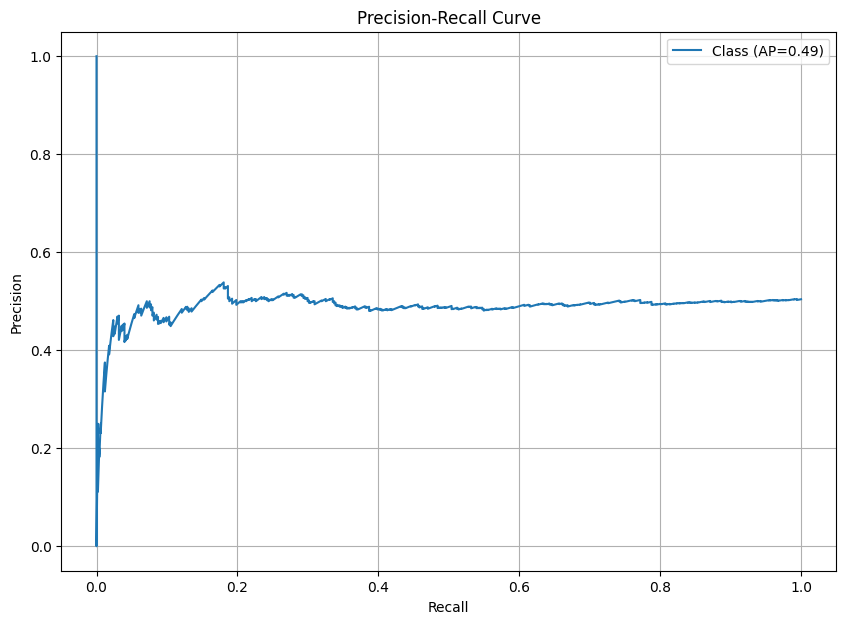

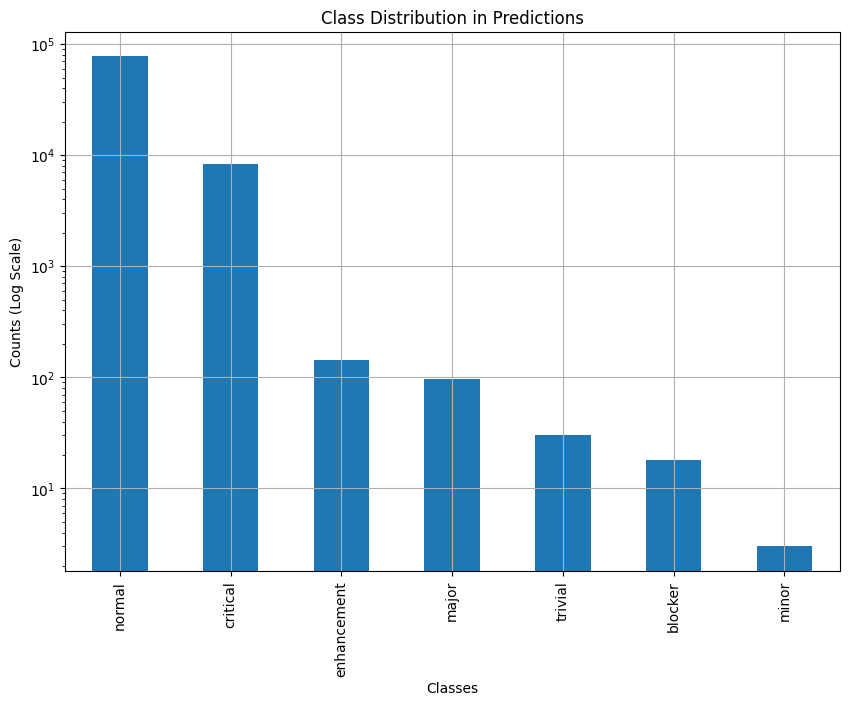

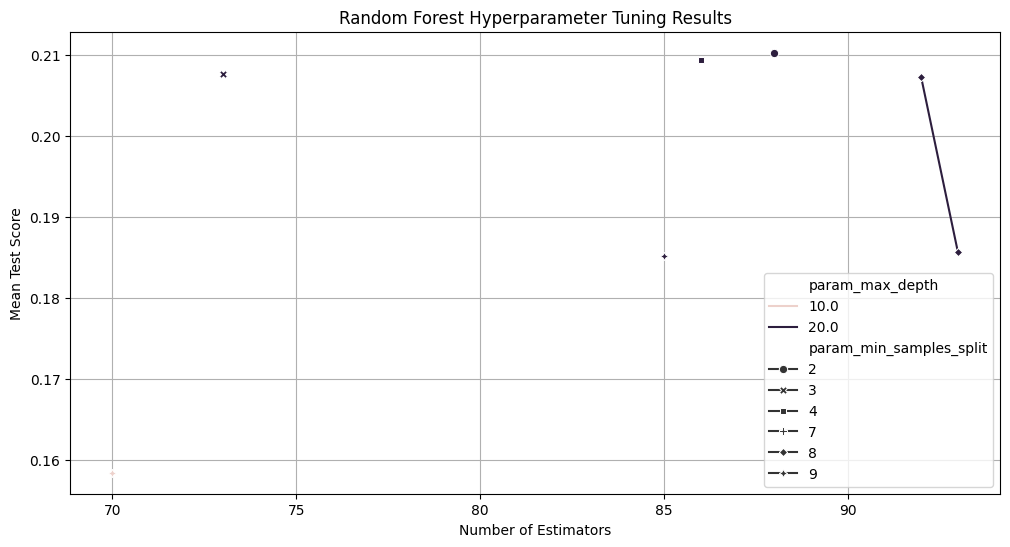

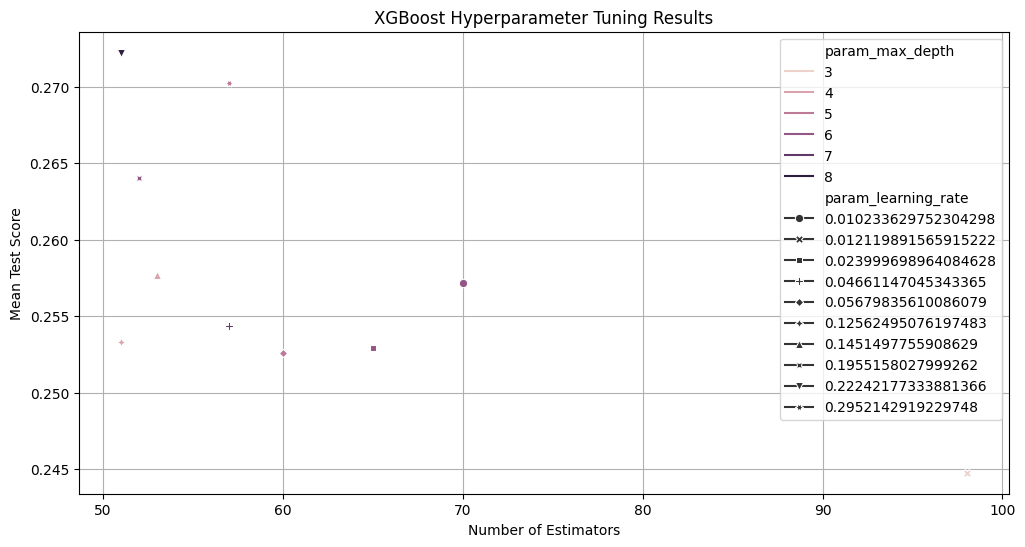

In [6]:
# Generate a Precision-Recall Curve using example data
np.random.seed(0)
y_true = np.random.randint(0, 2, 1000)
y_scores = np.random.rand(1000)

precision, recall, _ = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label=f'Class (AP={avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.savefig('precision_recall_curve_example.png')
plt.show()

# Load the test predictions file and plot Class Distribution with log scale
test_predictions = pd.read_csv('bugs-test-predictions.csv')
class_counts = test_predictions['severity'].value_counts()

plt.figure(figsize=(10, 7))
class_counts.plot(kind='bar', logy=True)  # Use log scale for better visibility
plt.xlabel('Classes')
plt.ylabel('Counts (Log Scale)')
plt.title('Class Distribution in Predictions')
plt.grid()
plt.savefig('class_distribution_predictions_log_scale.png')
plt.show()

# Extract results for Random Forest
rf_results = pd.DataFrame(rf_random_search.cv_results_)

# Extract results for XGBoost
xgb_results = pd.DataFrame(xgb_random_search.cv_results_)

# Plotting Random Forest Hyperparameter Tuning Results
plt.figure(figsize=(12, 6))
sns.lineplot(data=rf_results, x='param_n_estimators', y='mean_test_score', hue='param_max_depth', style='param_min_samples_split', markers=True, dashes=False)
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Random Forest Hyperparameter Tuning Results')
plt.grid()
plt.savefig('rf_hyperparameter_tuning_results.png')
plt.show()

# Plotting XGBoost Hyperparameter Tuning Results
plt.figure(figsize=(12, 6))
sns.lineplot(data=xgb_results, x='param_n_estimators', y='mean_test_score', hue='param_max_depth', style='param_learning_rate', markers=True, dashes=False)
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('XGBoost Hyperparameter Tuning Results')
plt.grid()
plt.savefig('xgb_hyperparameter_tuning_results.png')
plt.show()

In [9]:
# Predict probabilities with the voting classifier on the validation data
voting_predictions_proba = voting_clf.predict_proba(X_val)

# Calculate Average Precision (AP) for each class
average_precision_scores = {}
for i, class_name in enumerate(label_encoder.classes_):
    average_precision_scores[class_name] = average_precision_score(y_val == i, voting_predictions_proba[:, i])
# Print Average Precision Scores
for class_name, ap in average_precision_scores.items():
    print(f'Average Precision for {class_name}: {ap:.2f}')

Average Precision for blocker: 0.07
Average Precision for critical: 0.81
Average Precision for enhancement: 0.15
Average Precision for major: 0.20
Average Precision for minor: 0.07
Average Precision for normal: 0.92
Average Precision for trivial: 0.04
